In [906]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

### Data Prep

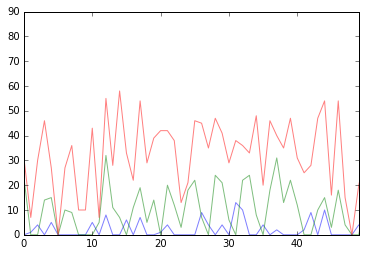

In [802]:
# New data
ts_daily_old = np.load('timeseries_daily_rentals.npy')[:, 1:]
ts_daily = ts_daily_old[~np.all(ts_daily_old == 0, axis=1)]
total_stations = ts_daily.shape[0]
n_stations = 3
stations = np.random.permutation(total_stations)[:n_stations]
obs = ts_daily[stations, :]
for i in range(len(obs)):
    plt.plot(obs[i], alpha=0.5)
plt.xlim(0, 49)
plt.show()

In [971]:
# Construct true alignments and true row permutation
true_A_orig = np.random.choice(range(7), n_stations)
true_M = np.random.permutation(n_stations)
inc = 3

true_M_matrix = np.zeros((n_stations, n_stations), dtype=int)
for i in range(n_stations):
    true_M_matrix[i, true_M[i]] = 1
    
test_orig = np.empty((n_stations, inc))
for i in range(n_stations):
    test_orig[i] = obs[i, 224+true_A_orig[i]:224+inc+true_A_orig[i]]
    
# Permute data
test = np.dot(true_M_matrix, test_orig)
true_A = np.dot(true_M_matrix, true_A_orig)

In [284]:
# Synthetic data - OUTDATED
obs_syn = np.array(range(obs.size)).reshape(obs.shape) / 1000.
test_syn = np.empty((n_stations, 7))

for i in range(n_stations):
    test_syn[i] = obs_syn[i, true_A_orig[i]:7+true_A_orig[i]]
    
test_syn_perm = np.dot(true_M_matrix, test_syn)

### Optimization

In [1011]:
def get_M_mean(alignments, obs, test, n_stations, n_weeks, inc):
    """
    Non-greedily computes the optimal M for test given alignments and observed data.
    """
    M = 999 * np.ones(n_stations, dtype=int)
    best_idx = 999
    dists_list = []
        
    for idx, row in enumerate(test):
        dists = np.linalg.norm(row - obs[:, alignments[idx]:alignments[idx]+inc], axis=1)
        for i in range(1, n_weeks):
            dists += np.linalg.norm(row - obs[:, alignments[idx]+7*i:alignments[idx]+7*i+inc], axis=1)
        dists_list.append(dists / dists.sum())
        
    for i in range(n_stations):
        # Find the smallest distance from a station for any time series
        best_ts = np.argmin([np.min(d) for d in dists_list])
        while (best_idx in M):
            # Find the index that produced that smallest distance
            best_idx = np.random.choice(range(n_stations), p=(1 / dists_list[best_ts]) / (1 / dists_list[best_ts]).sum())
            
        M[best_ts] = best_idx
        dists_list[best_ts] = np.inf

    # Make sure no two test rows are assigned to the same observation
    assert np.unique(M).shape[0] == n_stations, 'shape is {}'.format(np.unique(placements).shape[0])
    
    # Make sure no infs made it through
    assert np.isinf(M).sum() == 0
    return M

def get_alignments_mean(M, obs, test, n_stations, n_weeks, inc):
    """
    Computes the best alignments given M.
    """
    new_alignments = np.zeros_like(M)
    
    # Find the best alignments
    for i in range(n_stations):
        # Store the alignment data in probs
        probs = np.zeros(7)
        
        # Calculate the alignments for each row of test
        for j in range(7):
            for k in range(n_weeks):
                probs[j] += np.linalg.norm(test[i] - obs[M[i], j+(k*7):j+(7*(k))+inc])
            
        # Choose the best alignment
        probs = (1 / probs) / (1 / probs).sum()
        new_alignments[i] = np.random.choice(range(len(probs)), p=probs)
    return new_alignments

In [900]:
def maximize(obs, test, true_M, true_A, n_weeks, n_stations, n_iter, inc):
    states = []
    A = np.random.choice(range(7), n_stations)
    old_A = np.zeros_like(A)
    M = np.random.permutation(n_stations)
    old_M = np.zeros_like(M)
    best_M, best_A = None, None
    best_err_old = np.inf

    for i in range(n_iter):
            
        ##############
        ### Step 1 ###
        ##############

        # Assume the alignments are right and figure out the best M
        M = get_M_mean(A, obs, test, n_stations, n_weeks, inc)

        ##############
        ### Step 2 ###
        ##############

        # Assume M is right and figure out the best alignments
        A = get_alignments_mean(M, obs, test, n_stations, n_weeks, inc)
        states.append(((M == old_M).sum(), (A == old_A).sum()))
        
        best_err = 0
        for idx, row in enumerate(test):
            for j in range(n_weeks):
                best_err += np.linalg.norm(row - obs[M[idx], A[idx]+7*j:A[idx]+7*(j)+inc])
        if best_err < best_err_old or True:
            best_M = M
            best_A = A
            best_err_old = best_err            
            
        old_M = M
        old_A = A
    return best_M, best_A, states, best_err

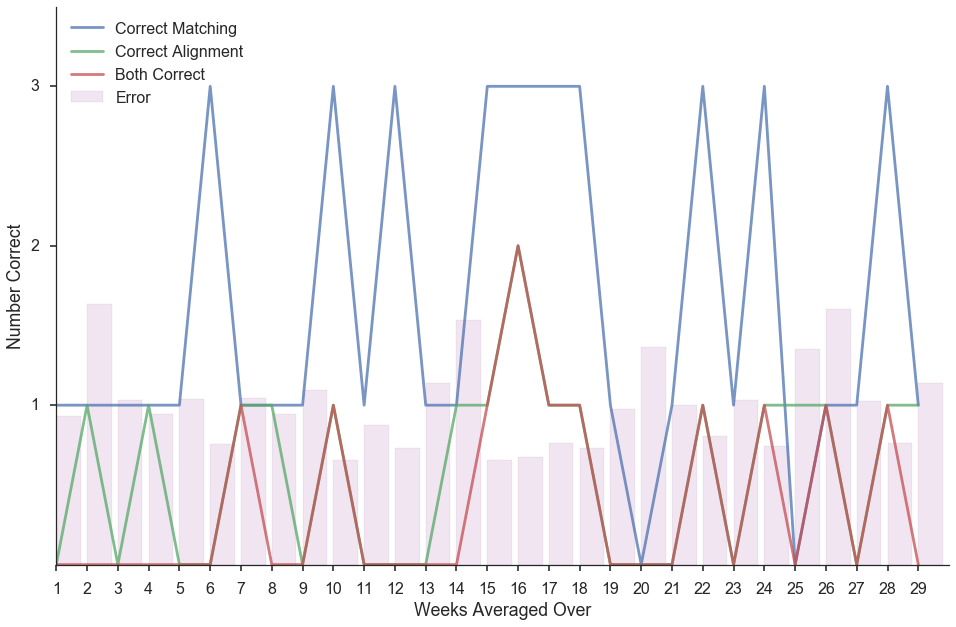

In [1025]:
# Run the maximization

n_weeks = 30
M_match_mean = []
A_match_mean = []
match_mean = []
states = []
errs = []
for n in range(1, n_weeks):
#     print '{} WEEKS\n'.format(n)
    M, A, s, be = maximize(obs[:, 14:], test, true_M, true_A, n, n_stations, 50, inc)
    M_match_mean.append((M == true_M).sum())
    A_match_mean.append((A == true_A).sum())
    match_mean.append(((M == true_M) & (A == true_A)).sum())
    states.append(s)
    errs.append(be / n)
plot_results(M_match_mean, A_match_mean, match_mean, n_weeks, errs, n_stations)

### Plotting

In [1024]:
def plot_results(M, A, match, n_weeks, errs, n_stations):
    sns.set_context("poster")
    plt.figure(figsize=(16,10))
    sns.set_style("white")
    sns.set_style("ticks")
    plt.plot(range(1, n_weeks), M, label='Correct Matching', alpha=0.75)
    plt.plot(range(1, n_weeks), A, label='Correct Alignment', alpha=0.75)
    plt.plot(range(1, n_weeks), match, label='Both Correct', alpha=0.75)
    plt.bar(range(1, n_weeks), errs / np.mean(errs), alpha=0.1, label='Error', color='purple')
    plt.legend(loc=2)
    plt.xlim(1, n_weeks)
    plt.xticks(np.arange(1, n_weeks, 1.0))
    plt.yticks(np.arange(1, n_stations+1, 1.0))
    plt.xlabel('Weeks Averaged Over')
    plt.ylabel('Number Correct')
    sns.despine()
    plt.ylim(0, np.max([np.max(M), np.max(A), np.max(match)]) + 0.5)
    plt.show();

### Miscellaneous Unused/Outdated Functions

In [51]:
def get_M_greedy(alignments, obs, test, n_stations):
    """
    Greedily computes the optimal M for test given alignments and observed data.
    """
    placements = []
    for idx, row in enumerate(test):
        dists = np.linalg.norm(row - obs[:, alignments[idx]:alignments[idx]+7], axis=1)
        best_idx = np.argmin(dists)
        c = 0
        while (best_idx in placements):
            dists[best_idx] = np.inf
            best_idx = np.argmin(dists)
            c += 1
            if c >= 120:
                raise ValueError("dists is {}".format(dists))
                
        placements.append(best_idx)
        if c >= 120:
            raise ValueError("dists is {}".format(dists))
        
    # Make sure no two test rows are assigned to the same observation
    placements = np.array(placements, dtype=int)
    assert np.unique(placements).shape[0] == n_stations, 'shape is {}'.format(np.unique(placements).shape[0])
    return placements

def get_M(alignments, obs, test, n_stations, n_weeks):
    """
    Non-greedily computes the optimal M for test given alignments and observed data.
    """
    M = 999 * np.ones(n_stations, dtype=int)
    best_idx = 999
    dists_list = []
    
    # Get a list of distances from each station for each time series in test
    for idx, row in enumerate(test):
        dists = np.linalg.norm(row - obs[:, alignments[idx]:alignments[idx]+7], axis=1)
        dists_list.append(dists)
        
    for i in range(n_stations):
        while (best_idx in M):
            # Find the smallest distance from a station for any time series
            best_ts = np.argmin([np.min(d) for d in dists_list])

            # Find the index that produced that smallest distance
            best_idx = np.argmin(dists_list[best_ts])
            dists_list[best_ts][best_idx] = np.inf
            
        M[best_ts] = best_idx
        dists_list[best_ts] = np.inf

    # Make sure no two test rows are assigned to the same observation
    assert np.unique(M).shape[0] == n_stations, 'shape is {}'.format(np.unique(placements).shape[0])
    return M

def get_alignments(M, obs, test, n_stations, n_weeks):
    """
    Computes the best alignments given M.
    """
    new_alignments = np.zeros_like(M)
    
    # Find the best alignments
    for i in range(n_stations):
        # Store the alignment data in probs
        probs = np.zeros(7)
        
        # Calculate the alignments for each row of test
        for j in range(7):
            probs[j] = np.linalg.norm(test[i] - obs[M[i], j:j+7])
            
        # Choose the best alignment
        new_alignments[i] = np.argmin(probs)
        
    return new_alignments